# Case Study of Confusion Matrices

In [1]:
import sys
import os

import polars as pl
import pandas as pd
import numpy as np

In [2]:
sys.path.append(f"../../methods")
sys.path.append(f"../")

In [3]:
from hsds_em import HSDS_EM
from crowdkit.aggregation import DawidSkene, OneCoinDawidSkene

In [4]:
from hsds_stan import HSDS_Stan, SeparatedBDS

In [5]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [6]:
from io_utils import get_accuracy, get_recall

## Setup the specific condition
face, homo, r=5, AI_acc=mean, num_ai=15

In [7]:
gt = pd.read_csv("../human_responses/face_gt.csv")
biased_index = gt[gt["gt"]==0]["task"].unique()
gt = gt.set_index("task")

In [8]:
human = pd.read_csv("../human_responses/face_r=5.csv")

In [9]:
for run in range(15):
    tmp_df = pd.read_csv(f"../ai_responses/face_r=5_ai=mean_target=1_run={run}.csv")
    if run == 0:
        ai_df = tmp_df
    else:
        ai_df = pd.concat([ai_df, tmp_df], ignore_index=True)

In [10]:
df = pd.concat([human, ai_df], ignore_index=True)

## Utils

In [11]:
def ds_errors_to_numpy_dict(errors_df):
    workers = errors_df.index.get_level_values(0).unique()
    labels = errors_df.columns
    label_values = errors_df.index.get_level_values(1).unique()
    result = {}
    for worker in workers:
        sub_df = errors_df.loc[worker]
        sub_df = sub_df.reindex(label_values).sort_index()
        result[worker] = sub_df.values.T
    return result

In [12]:
def calc_avg_mat(mats):
    ai_mat = np.zeros((4,4))
    ai_cnt = 0
    human_mat = np.zeros((4,4))
    human_cnt = 0
    for key, mat in mats.items():
        mat = np.nan_to_num(mat)
        if key[:3] == "AI_":
            ai_mat += mat
            ai_cnt += 1
        else:
            human_mat += mat
            human_cnt += 1
    ai_mat /= ai_cnt
    human_mat /= human_cnt
    return human_mat, ai_mat

## Algorithms

### DS

In [13]:
ds = DawidSkene()
ret = ds.fit_predict(df)

In [14]:
get_accuracy(ret, gt)

0.839041095890411

In [15]:
get_recall(ret, gt, biased_index)

0.3904109589041096

In [16]:
ds_mats = ds_errors_to_numpy_dict(ds.errors_)

In [17]:
# Print Averaged Human CM and AI CM
ds_h_cm, ds_a_cm = calc_avg_mat(ds_mats)
ds_h_cm, ds_a_cm

(array([[0.81949769, 0.01522621, 0.08535922, 0.07991688],
        [0.34521026, 0.59706982, 0.02543801, 0.0322819 ],
        [0.46521575, 0.03392993, 0.38729941, 0.11355491],
        [0.39133835, 0.23931093, 0.0705083 , 0.29884242]]),
 array([[0.0675846 , 0.6828647 , 0.12530257, 0.12424813],
        [0.07548384, 0.79024583, 0.06435542, 0.06991491],
        [0.08596104, 0.07266778, 0.7662655 , 0.07510568],
        [0.08957667, 0.07578601, 0.07969529, 0.75494203]]))

### HSDS-EM

In [18]:
hds = HSDS_EM()
ret = hds.fit_predict(human,ai_df)

In [19]:
get_accuracy(ret, gt)

0.946917808219178

In [20]:
get_recall(ret, gt, biased_index)

0.952054794520548

In [21]:
hds_mats = ds_errors_to_numpy_dict(hds.step2_ds.errors_)

In [22]:
# Print Averaged Human CM and AI CM
hds_h_cm, hds_a_cm = calc_avg_mat(hds_mats)
hds_h_cm, hds_a_cm

(array([[0.81142866, 0.05412829, 0.05905662, 0.07538644],
        [0.052499  , 0.93167256, 0.01309762, 0.00273081],
        [0.46872008, 0.02998134, 0.38756825, 0.11373032],
        [0.39239287, 0.2394462 , 0.07019081, 0.29797012]]),
 array([[0.07103676, 0.75914199, 0.08149887, 0.08832238],
        [0.07756436, 0.77936816, 0.07193775, 0.07112973],
        [0.08564934, 0.07546685, 0.76281601, 0.07606781],
        [0.08933874, 0.07623929, 0.08162196, 0.75280001]]))

### OneCoin

In [23]:
ocds = OneCoinDawidSkene()
ret = ocds.fit_predict(df)

In [24]:
get_accuracy(ret, gt)

0.75

In [25]:
get_recall(ret, gt, biased_index)

0.0

In [26]:
ocmats = ds_errors_to_numpy_dict(ocds.errors_)

In [27]:
# Print Averaged Human CM and AI CM
ocd_h_cm, ocd_a_cm = calc_avg_mat(ocmats)
ocd_h_cm, ocd_a_cm

(array([[0.40404701, 0.198651  , 0.178651  , 0.15614119],
        [0.198651  , 0.40404701, 0.178651  , 0.15614119],
        [0.198651  , 0.198651  , 0.38404701, 0.15614119],
        [0.198651  , 0.198651  , 0.178651  , 0.33157642]]),
 array([[0.76424834, 0.07858389, 0.07858389, 0.07858389],
        [0.07858389, 0.76424834, 0.07858389, 0.07858389],
        [0.07858389, 0.07858389, 0.76424834, 0.07858389],
        [0.07858389, 0.07858389, 0.07858389, 0.76424834]]))

### BDS

In [73]:
infer_params = {
        "iter_warmup": 1500,
        "iter_sampling": 3000,
    }

In [74]:
bds = SeparatedBDS(labels=[0,1,2,3], algorithm="mcmc", infer_params=infer_params, init_worker_accuracy=0.75)

In [75]:
bds_ret = bds.fit_predict(human, ai_df)

06:24:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

06:26:24 - cmdstanpy - INFO - CmdStan done processing.



Checking Rhat values
p (r_hat > 1.1): 4
pih:
	Class 0 (r_hat > 1.1): 62
	Class 1 (r_hat > 1.1): 58
	Class 2 (r_hat > 1.1): 67
	Class 3 (r_hat > 1.1): 70
pia:
	Class 0 (r_hat > 1.1): 59
	Class 1 (r_hat > 1.1): 17
	Class 2 (r_hat > 1.1): 46
	Class 3 (r_hat > 1.1): 54


In [76]:
get_accuracy(bds_ret, gt)

0.4606164383561644

In [77]:
get_recall(bds_ret, gt,biased_index)

0.0

In [78]:
bds_pih = bds.step2_fit.stan_variable("pih")

In [79]:
bds_pih = bds_pih.mean(axis=0)

In [80]:
bds_h_cm = bds_pih.mean(axis=0)

In [81]:
# Print Averaged Human CM
bds_h_cm

array([[0.65508344, 0.10739726, 0.08664483, 0.15087447],
       [0.12826857, 0.7730283 , 0.05015689, 0.04854625],
       [0.21944263, 0.08255423, 0.56360456, 0.13439858],
       [0.3405554 , 0.08869698, 0.11855405, 0.45219357]])

In [82]:
bds_pia = bds.step2_fit.stan_variable("pia")

In [83]:
bds_pia = bds_pia.mean(axis=0)

In [84]:
bds_a_cm = bds_pia.mean(axis=0)

In [85]:
# Print Averaged AI CM
bds_a_cm

array([[0.14609024, 0.23765579, 0.22415264, 0.39210132],
       [0.07769471, 0.77774335, 0.07078444, 0.0737775 ],
       [0.08468071, 0.07452667, 0.60667552, 0.2341171 ],
       [0.07909823, 0.39410002, 0.23911302, 0.28768872]])

## HS-DS MCMC

In [86]:
infer_params = {
        "iter_warmup": 1500//2,
        "iter_sampling": 3000//2,
    }

In [87]:
hsbds = HSDS_Stan(labels=[0,1,2,3], algorithm="mcmc", infer_params=infer_params, init_worker_accuracy=0.75)

In [88]:
ret = hsbds.fit_predict(human, ai_df)

06:27:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

06:27:50 - cmdstanpy - INFO - CmdStan done processing.


06:28:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

06:29:09 - cmdstanpy - INFO - CmdStan done processing.



Checking Rhat values
p (r_hat > 1.1): 0
pih:
	Class 0 (r_hat > 1.1): 0
	Class 1 (r_hat > 1.1): 0
	Class 2 (r_hat > 1.1): 0
	Class 3 (r_hat > 1.1): 0
pia:
	Class 0 (r_hat > 1.1): 0
	Class 1 (r_hat > 1.1): 0
	Class 2 (r_hat > 1.1): 0
	Class 3 (r_hat > 1.1): 0


In [89]:
get_accuracy(ret, gt)

0.9503424657534246

In [90]:
get_recall(ret, gt, biased_index)

0.9726027397260274

In [91]:
hsbds_pih = hsbds.step2_fit.stan_variable("pih")

In [92]:
hsbds_pih = hsbds_pih.mean(axis=0)

In [93]:
hsbds_h_cm = hsbds_pih.mean(axis=0)

In [94]:
# Print Averaged Human CM
hsbds_h_cm

array([[0.75625633, 0.07951809, 0.07677175, 0.08745384],
       [0.06287003, 0.8452188 , 0.04752107, 0.0443901 ],
       [0.25964944, 0.06212911, 0.56500349, 0.11321796],
       [0.23728335, 0.14040439, 0.08584235, 0.53646991]])

In [95]:
hsbds_pia = hsbds.step2_fit.stan_variable("pia")

In [96]:
hsbds_pia = hsbds_pia.mean(axis=0)

In [97]:
hsbds_a_cm = hsbds_pia.mean(axis=0)

In [98]:
# Print Averaged AI CM
hsbds_a_cm

array([[0.11709621, 0.71416654, 0.08128155, 0.0874557 ],
       [0.07787767, 0.78033776, 0.06953329, 0.07225128],
       [0.08508872, 0.07569821, 0.76245363, 0.07675944],
       [0.08890467, 0.07673848, 0.08055895, 0.7537979 ]])

In [99]:
# clean up
!rm -r ./outputs

## Visualization

In [100]:
from matplotlib import pyplot as plt

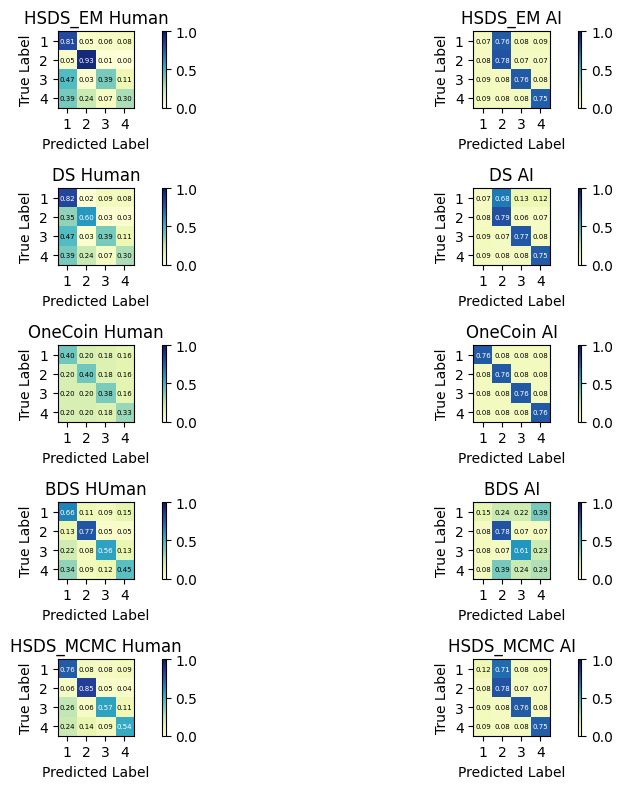

In [101]:
fig, axes = plt.subplots(5, 2, figsize=(10, 8))
cmaps = ["YlGnBu" for i in range(10)]
titles = ['HSDS_EM Human', 'HSDS_EM AI', 'DS Human', 'DS AI', 
          'OneCoin Human', 'OneCoin AI', "BDS HUman", "BDS AI", "HSDS_MCMC Human", "HSDS_MCMC AI"]
cms = [hds_h_cm, hds_a_cm, ds_h_cm, ds_a_cm, ocd_h_cm, ocd_a_cm, bds_h_cm, bds_a_cm, hsbds_h_cm, hsbds_a_cm]

for ax, cm, cmap, title in zip(axes.flat, cms, cmaps, titles):
    im = ax.imshow(cm, cmap=cmap, vmin=0, vmax=1)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = "white" if cm[i, j] > 0.5 else "black"
            ax.text(j, i, format(cm[i, j], '.2f'),
                    ha="center", va="center",
                    color=text_color, fontsize=5)
    ax.set_title(title)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_yticks([0,1,2,3])
    ax.set_yticklabels([1,2,3,4])
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels([1,2,3,4])
    fig.colorbar(im, ax=ax, orientation='vertical')

plt.tight_layout()
plt.savefig("cm.svg", bbox_inches="tight")
plt.show()